# Mujoco学习笔记
## 总览

### 新的变化
`MuJoCo`已经开源，可以直接通过pip安装
```
pip install mujoco
```
> 注意：mujoco安装方式的变化
- `mujoco_py`和`mjpro150`或者`mjpro210`啥的都成为历史了(参考:https://github.com/deepmind/mujoco/issues/347)
- 为了更方便使用`MuJoCo`可以安装`dm_control`，这也是官方教程中推荐的使用方式
```
pip install dm_control
```

### 如何学习
- 官方jupyter教程：
    - [mujoco原生python支持](https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb)
    - [dm_control教程](https://github.com/deepmind/mujoco/blob/main/python/tutorial.ipynb)
- [官方文档](https://mujoco.readthedocs.io/en/latest/overview.html)
    - 重点参考1：[MJCF编写指南](https://mujoco.readthedocs.io/en/latest/XMLreference.html)
    - 重点参考2：[API文档](https://mujoco.readthedocs.io/en/latest/APIreference/index.html)(虽然是C版本的，但是命名方式和python类似，结合jupyter教程可以了解如何使用)
- Github仓库和issue (尤其留意issue，因为目前版本迭代非常快，很多新功能被逐步加入)
    - [mujoco](https://github.com/deepmind/mujoco)
    - [dm_control](https://github.com/deepmind/dm_control)
> 注意：一定要区分开源前的教程和开源后的教程！

## 最小测试

In [1]:
# 导入一些便于测试的库
import mediapy as media # 渲染图像、视频的显示
import numpy as np

In [2]:
# 第一步：定义MJCF
mjcf = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

#### 原生的最小测试

""

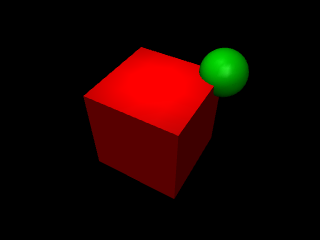

In [10]:
import mujoco as mjc
# 第二步：生成Model和Data，这是Mujoco中最重要的两个结构体，储存了仿真中的各种数据
# Model参考：https://mujoco.readthedocs.io/en/latest/APIreference/APItypes.html#mjmodel
# Data参考：https://mujoco.readthedocs.io/en/latest/APIreference/APItypes.html#mjdata
model = mjc.MjModel.from_xml_string(mjcf)
data = mjc.MjData(model)
# 第三步：仿真一个步进
# 函数参考：https://mujoco.readthedocs.io/en/latest/APIreference/APIfunctions.html#main-simulation
# 有mj_step、mj_forward等不同的步进仿真函数，有细微区别，主要是为了根据不同场合避免不必要的计算进而加速仿真
mjc.mj_step(model, data)
# 第四步：渲染图像，注意，此处开始需要OpenGL>1.5版本的支持
renderer = mjc.Renderer(model)
renderer.update_scene(data)
media.show_image(renderer.render())

#### `dm_control`的最小测试

In [3]:
import dm_control.mujoco as mj
# 第二步有所区别
physics = mj.Physics.from_xml_string(mjcf)
model,data = physics.model,physics.data # model和data隐藏在physics里
# 第三步一样，但对于只渲染图像可以省去，第四步不同
# media.show_image(physics.render())

从最小测试可见，`mujoco`和`dm_control.mujoco`类似但又有所不同：
- 从实现而言，`dm_control.mujoco`是`mujoco`的更高层次封装，因此在实际使用时更为简单，并且支持`dm_control`中的一些便捷工具，比如`dm_control.mjcf`这个库
- 不足的是目前还没有很好的交互式界面(`dm_control.viewer`只能用于已经设计好的环境，并不支持直接对`model`进行可视化交互)，但`2.3`以后的版本更新的`mujoco.viewer`提供了不错的交互

因此，最终确定仿真器以`dm_control.mujoco`为主，可视化交互使用`mujoco.viewer`
## 辅助可视化

### 视频序列渲染
> 注意：视频序列渲染需要支持`ffmpeg`

出现错误：`RuntimeError: Requested MovieWriter (ffmpeg) not available`

需要安装`ffmpeg`(动画输出)：
```
conda install -c conda-forge ffmpeg
```

In [5]:
# 为了让视频输出能到更高的分辨率，需要设置视觉全局参数offwidth、offheight
# 参考：https://mujoco.readthedocs.io/en/stable/XMLreference.html#visual-global
mjcf = """
<mujoco>
  <visual> 
  <global offwidth="1920" offheight="1080"/>
  </visual>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
def output_video(physics,duration,framerate=30,width=1920,height=1080):
  """duration时长，framerate帧率，width、height图像宽高，必须小于offwidth、offheight"""
  frames = []
  physics.reset()  # Reset state and time
  while physics.data.time < duration:
    physics.step()
    if len(frames) < physics.data.time * framerate:
      pixels = physics.render(width=width,height=height)
      frames.append(pixels)
  return frames
  
# 生成帧序列
duration = 2
framerate = 30
physics = mj.Physics.from_xml_string(mjcf)
frames=output_video(physics,duration,framerate,1920,1080)
# 显示
media.show_video(frames, fps=framerate)

### 交互式GUI
在新版本(`>2.3.1`)的`mujoco`中已经集成交互式GUI，但从`dm_control`的`physics`传递过来需要注意
- `import`时的不同版本`mujoco`，建议一定用`as`做区分
- `physics.model`并不是原生的`model`，而`model.ptr`才是
- 必须重新加载模型,因为之前运行过的`mj_step`貌似会导致窗口未响应

(希望后期能够合并这个`viewer`,不然还是非常混乱)

In [11]:
# 注意一定要区分不同的mujoco
import mujoco as mjc
import mujoco.viewer as mjv
physics = mj.Physics.from_xml_string(mjcf)
# 注意：physics.model并不是原生的model，而model.ptr才是！！！
model,data = physics.model.ptr,physics.data.ptr
# 是否传入data决定交互界面中的动作交互会不会影响实际的data结果
mjv.launch(model,data)

In [17]:
# 非阻塞式交互界面(新版本特性,就非常实用了!)
mjv.launch_passive(model,data)
renderer = mjc.Renderer(model)
for i in range(10000):
    mj.mj_step(model, data)
    # dm_control的操作方式
    physics.named.model.geom_size['red_box']=np.array([np.sin(physics.data.time),np.cos(physics.data.time),0.2])
    # 原生的操作方式
    # model.geom('red_box').size=np.array([np.sin(data.time),np.cos(data.time),0.2])
    # 渲染必须用原生的操作
    renderer.update_scene(data)
    renderer.render()

### 辅助图形

## MJCF与建模

## 相机

## 光源